![img](https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

На этом занятии помимо базового функционала `pytorch` будет использоваться библиотека для зрения **`torchvision`**.

# Pytorch как конструктор

## Работа с датасетами

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Кастомный пример — датасет, загружающий изображения на основе путей и классов из текстового файла:

In [5]:
from torch.utils.data import Dataset
# default_loader - стандартная функция для загрузки изображений, использует accimage или PIL
from torchvision.datasets.folder import default_loader

class TxtList(Dataset):
    def __init__(self, path, transform=None, loader=default_loader):
        with open(path) as fin:
            self.imgs = [s.strip().split() for s in fin.readlines()]

        print(f'=> Found {len(self.imgs)} entries in {path}')

        self.classes = sorted(set([_[1] for _ in self.imgs]))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        target = self.class_to_idx[target]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
!echo '/tmp/1.jpg\tcat' > /tmp/dataset.tsv
!echo '/tmp/2.jpg\tcat' >> /tmp/dataset.tsv
!echo '/tmp/3.jpg\tdog' >> /tmp/dataset.tsv
!echo '/tmp/4.jpg\tcat' >> /tmp/dataset.tsv

In [7]:
catdog = TxtList('/tmp/dataset.tsv')

=> Found 4 entries in /tmp/dataset.tsv


In [8]:
catdog.classes

['cat', 'dog']

In [9]:
catdog.imgs

[['/tmp/1.jpg', 'cat'],
 ['/tmp/2.jpg', 'cat'],
 ['/tmp/3.jpg', 'dog'],
 ['/tmp/4.jpg', 'cat']]

In [10]:
len(catdog)

4

In [11]:
# FileNotFoundError
catdog[0]

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/1.jpg'

`torchvision` также содержит и другие готовые классы для стандартных датасетов: 
http://pytorch.org/docs/master/torchvision/datasets.html.

Некоторые из них можно сразу и загрузить — например, **MNIST**:

In [18]:
![ -d '/tmp/mnist/' ] && rm -r '/tmp/mnist/'

In [19]:
from torchvision.datasets import MNIST

%time mnist = MNIST('/tmp/mnist/', train=True, download=True)

Processing...
Done!
CPU times: user 251 ms, sys: 195 ms, total: 446 ms
Wall time: 3.65 s


In [20]:
len(mnist)

60000

In [21]:
image, target = mnist[0]
print(target)

tensor(5)


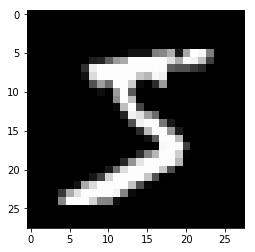

In [22]:
plt.imshow(np.array(image), 'gray')
plt.show()

## <font color='#cc6666'>Внимание, задача!</font>

Релизуйте ниже датасет **`UrlList`**, конструктор которого на вход принимает список ссылок на изображения.

In [23]:
import requests
from PIL import Image

def my_default_loader(path):
    return Image.open(path).convert('RGB')

class UrlList(Dataset):
    def __init__(self, url_list, transform=None, loader=my_default_loader):
        self.imgs = []
        for url in url_list:
            self.imgs.append(requests.get(url, stream=True).raw)

        print(f'=> Found {len(self.imgs)} entries in list')

        self.transform = transform
        self.loader = loader
        
    def __getitem__(self, index):
        path = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.imgs)

Покажите его работу на примере:

=> Found 8 entries in list
8


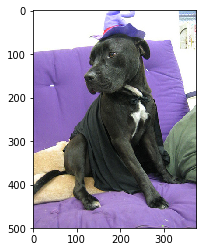

In [24]:
url_list = [
    'http://farm3.static.flickr.com/2072/2088622613_2660469c6c.jpg',#cat
    'http://farm2.static.flickr.com/1245/1259825348_6a2aa94e8d.jpg',
    'http://farm1.static.flickr.com/180/392497682_a04247e176.jpg',#dog
    'http://farm1.static.flickr.com/105/288106053_7539c6de2b.jpg',
    'http://farm2.static.flickr.com/1104/1133697429_1545da51ed.jpg',
    'http://farm1.static.flickr.com/135/331620804_e315322a82.jpg',#cat
    'http://farm1.static.flickr.com/228/473323308_9dba272940.jpg', #dog
    'http://farm1.static.flickr.com/51/139716834_dcf481d509.jpg'
]

catdog2 = UrlList(url_list)
print(len(catdog2))
plt.imshow(catdog2[3])
plt.show()

## Преобразования данных

Конструктор примера, приведенного выше, также как и стандартного `ImageFolder`, принимают параметр `transform` (и `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований:

In [25]:
from torchvision import transforms

Например, `transforms.ToTensor()` преобразует `PIL`-изображение типа uint8 с доменом [0, 256) в тензор с доменом [0, 1].

In [26]:
to_tensor = transforms.ToTensor()

In [27]:
pil_image = mnist[0][0]
th_image = to_tensor(pil_image)
th_image.shape, th_image.min(), th_image.max()

(torch.Size([1, 28, 28]), tensor(0.), tensor(1.))

А для того, чтобы нормализовывать изображения из ImageNet'а по стандартной схеме, можно объявить

In [28]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Для объединения нескольких преобразваний в одно есть `Compose`:

In [29]:
crop_and_tensorize = transforms.Compose([
    transforms.CenterCrop(16),
    transforms.ToTensor(),
])

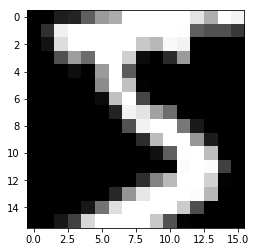

In [30]:
plt.imshow(crop_and_tensorize(pil_image)[0].numpy(), 'gray')
plt.show()

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

## <font color='#cc6666'>Внимание, задача!</font>

Реализуйте класс-трансформер, осуществляющий с подаваемым на вход изображением случайное преобразование из группы диэдра $D_4$.

In [31]:
from PIL import Image
from scipy.ndimage import interpolation
class RandomD4(object):
    def __call__(self, img):
        tf_list = [
            np.array([1, 0, 0, 1]).reshape((2, 2)),
            np.array([0, -1, 1, 0]).reshape((2, 2)),
            np.array([-1, 0, 0, -1]).reshape((2, 2)),
            np.array([0, 1, -1, 0]).reshape((2, 2)),
            np.array([1, 0, 0, -1]).reshape((2, 2)),
            np.array([0, 1, 1, 0]).reshape((2, 2)),
            np.array([-1, 0, 0, 1]).reshape((2, 2)),
            np.array([0, -1, -1, 0]).reshape((2, 2)),
        ]
        x = tf_list[np.random.randint(0, 8)]
        img = np.asarray(img)
        iy = img.shape[0]
        ix = img.shape[1]
        offset = np.zeros((2,), dtype=np.float64)
        offset[0] = float(iy) / 2.0 - 0.5
        offset[1] = float(ix) / 2.0 - 0.5
        tmp = np.array(offset)
        offset = np.dot(x, offset)
        offset = tmp - offset
        tf_img = interpolation.affine_transform(img, x, offset)
        return tf_img

Покажите его работу на примере из MNIST:

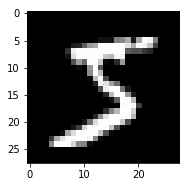

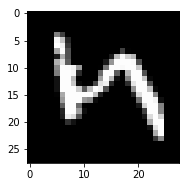

In [32]:
transform = RandomD4()
pil_image = mnist[0][0]
th_image = transform(pil_image)
plt.subplot(1,2,1)
plt.imshow(np.array(pil_image), 'gray')
plt.show()
plt.subplot(1,2,2)
plt.imshow(th_image, 'gray')
plt.show()

## Загрузчики данных

Основная магия, для которой и нужны датасеты в приведенном выше виде, это загрузчики:

In [33]:
from torch.utils.data import DataLoader

Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

При этом батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах!

Рассмотрим их на примере с MNIST, при этом добавим к нему трансформер, т.к. лоадеры работают с тензорами или скалярами, но не `PIL.Image`.

In [34]:
transformed_mnist = MNIST('/tmp/mnist/', train=True, transform=transforms.ToTensor())

In [35]:
mnist_loader = DataLoader(transformed_mnist, batch_size=16, shuffle=True, num_workers=4)  # замечение про shuffle

Стандартные параметры приведены выше. При добавлении **`pin_memory=True`** батчи еще и сразу раскладываются по видеокартам.

Посмотрим на работу в деле:

In [36]:
for images, targets in tqdm(mnist_loader):
    pass

100%|██████████| 3750/3750 [00:02<00:00, 1554.55it/s]


На выходе из лоадера получаем батчи:

In [37]:
images.shape

torch.Size([16, 1, 28, 28])

In [38]:
targets.shape

torch.Size([16])

Количество батчей заранее известно (чему был рад `tqdm`):

In [39]:
len(mnist_loader)

3750

Пример данных (при каждом повторении прохода по мнисту пример будет случайным):

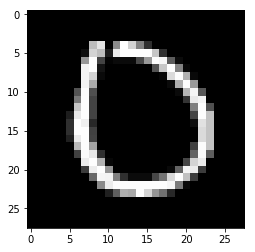

In [40]:
plt.imshow(images[0][0].numpy(), 'gray')
plt.show()

In [41]:
print(targets[0])

tensor(0)


## Создание моделей

Для создания моделей наследуемся от `torch.nn.Module`, `torch.nn` также содержит стандартные "кирпичики" моделей.

Функциональные версии кирпичей скрыты в `torch.nn.functional`.

In [42]:
import torch.nn as nn
import torch.nn.functional as F

Для макспулинга, активаций, апсемплинга и некоторых других операций есть как "модульные", так и "функциональные" версии:
* `nn.MaxPool2d` / `F.max_pool2d`
* `nn.ReLU` / `F.relu`
* `nn.Upsample(mode='bilinar')` / `F.upsample(mode='bilinar')` — **deprecated** в пользу `F.interpolate`

При использовании модульных версий слоев во время создания простой модели можно обходиться `nn.Sequential` для их "склейки":

In [43]:
layers = [
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU()
]
unet_down1 = nn.Sequential(*layers)
print(unet_down1)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
)


## Обучение моделей

Для обучения моделей необходимо определить функцию потерь, их примеры содержатся все в том же модуле `torch.nn`:

```python
output = model(torch.cat(x, 1))
target = torch.arange(1, 1001)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)
```

Веса обновлять можно как вручную (или воспользоваться реализованным ранее оптимизатором):

```python
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
```

Так и пользоваться стандартным оптимизатором из модуля `torch.optim`:
```python
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)
```

Для зануления градиентов теперь можно обращаться к оптимизатору:
```python
optimizer.zero_grad()
```

Инференс, подсчет ошибки и бэкпроп делаем как раньше:
```python
output = net(x)
loss = criterion(output, target)
loss.backward()
```

А для обновления весов используем оптимизатор:
```python
optimizer.step()
```

Для работы с шагом обучения в **`optim`** есть подмодуль **`torch.optim.lr_scheduler`**:
```python
from torch.optim import lr_scheduler
```

Например, обучение ResNet на ImageNet по стандартной схеме будет работать примерно так:
```python
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
for epoch in range(100):
     scheduler.step()  # == scheduler.step(epoch)
     # train(...)
     # validate(...)
```

# Pytorch в бою

## Создание модели сегментации на примере U-Net

![img](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [44]:
import torch
from torch import nn

Часто используемые свертки:

In [45]:
def conv3x3(in_channels, out_channels, dilation=1):
    return nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)

Один **блок кодировщика** состоит из двух последовательных сверток, активаций и опционального батчнорма:

In [46]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.batch_norm = batch_norm

        self.conv1 = conv3x3(in_channels, out_channels)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels)
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)
        return x

In [47]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [48]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


Альтернативное объявление:

In [49]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.block = nn.Sequential()
        self.block.add_module('conv1', conv3x3(in_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn1', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu1', nn.ReLU())
        self.block.add_module('conv2', conv3x3(out_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn2', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu2', nn.ReLU())

    def forward(self, x):
        return self.block(x)

In [50]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (block): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
)

In [51]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


И "функциональная версия":

In [52]:
def encoder_block(in_channels, out_channels, batch_norm=False):
    block = nn.Sequential()
    block.add_module('conv1', conv3x3(in_channels, out_channels))
    if batch_norm:
        block.add_module('bn1', nn.BatchNorm2d(out_channels))
    block.add_module('relu1', nn.ReLU())
    block.add_module('conv2', conv3x3(out_channels, out_channels))
    if batch_norm:
        block.add_module('bn2', nn.BatchNorm2d(out_channels))
    block.add_module('relu2', nn.ReLU())
    return block

In [53]:
block = encoder_block(3, 64)
block

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [54]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


Кодировщик в целом состоит из рассмотренных блоков.

Его конструкция определяется входными каналами, количеством фильтров в первом блоке и количеством блоков.

Помним также, что для работы сети нам нужно запоминать промежуточные активации.

In [55]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()

        self.num_blocks = num_blocks
        for i in range(num_blocks):
            in_channels = in_channels if not i else num_filters * 2 ** (i - 1)
            out_channels = num_filters * 2**i
            self.add_module(f'block{i + 1}', encoder_block(in_channels, out_channels))
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

Здесь как раз помогает подход к построению через с **`add_module`**, т.к. их количество переменно.

In [56]:
encoder = Encoder(in_channels=3, num_filters=8, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (conv1): Conv2d(32, 64, kernel_s

In [57]:
x = torch.zeros(4, 3, 512, 512)

[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

Блок декодировщика состоит из апскейлинга входа "снизу", объединения двух входов и сверток как в кодировщике:

In [58]:
class DecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.uppool = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upconv = conv3x3(out_channels * 2, out_channels)
        self.conv1 = conv3x3(out_channels * 2, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)

    def forward(self, down, left):
        x = self.uppool(down)
        x = self.upconv(x)
        x = torch.cat([left, x], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [59]:
block = DecoderBlock(8)

In [60]:
y = encoder(x)

In [61]:
y[1].shape, y[0].shape

(torch.Size([4, 16, 256, 256]), torch.Size([4, 8, 512, 512]))

In [62]:
block(y[1], y[0]).shape

/home/nadya/anaconda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/nadya/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([4, 8, 512, 512])

Декодировщик собираем из таких блоков:

In [63]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [64]:
decoder = Decoder(8, 3)

In [65]:
x.shape

torch.Size([4, 3, 512, 512])

In [66]:
[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

In [67]:
decoder(encoder(x)).shape

torch.Size([4, 8, 512, 512])

U-Net состоит из такого кодировщика и декодировщика, а также финального слоя классификации:

In [68]:
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=64, num_blocks=4):
        super().__init__()

        print(f'=> Building {num_blocks}-blocks {num_filters}-filter U-Net')

        self.encoder = Encoder(in_channels, num_filters, num_blocks)
        self.decoder = Decoder(num_filters, num_blocks - 1)
        self.final = nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

"Интеграционное тестирование" (pytorch 0.3):

In [ ]:
from torch.autograd import Variable

model = UNet(num_classes=1)
if torch.cuda.is_available():
    model.cuda()

images = Variable(torch.randn(4, 3, 416, 416), volatile=True)
if torch.cuda.is_available():
    images = images.cuda()

model.forward(images).shape

То же для **pytorch 0.4+**:

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

images = torch.randn(4, 3, 416, 416).to(device)

model.forward(images).shape

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([4, 1, 416, 416])

На выходе получаем бинарную маску из линейных активаций.

Для обучения такой модели используются функции потерь с **WithLogits** в названии.

В вероятности их можно превращать с помощью `torch.sigmoid` (**0.4.1+**) (`torch.nn.functional.sigmoid` ранее)

## Использование готового кодировщика

Структура блоков кодировщика рассмотренной только что сети сильно походит на таковую в сетях VGG:

![img](https://www.pyimagesearch.com/wp-content/uploads/2017/03/imagenet_vgg16.png)

Посмотрим на неё же из недр `torchvision`:

In [0]:
from torchvision.models import vgg13

VGG13 - версия сети с 2 сверткаим на каждый блок:

In [0]:
model = vgg13()

In [74]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace)
    (17): Conv2d

Классификатор нам не нужен, интересуют только признаки.

Они в свою очередь делятся на блоки conv-relu-conv-relu + maxpooling.

Реализуем кодировщик на основе вычленения нужных блоков:

In [0]:
class VGG13Encoder(nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()

        backbone = vgg13(pretrained=pretrained).features

        self.num_blocks = num_blocks
        for i in range(self.num_blocks):
            block = nn.Sequential(*[backbone[j] for j in range(i * 5, i * 5 + 4)])
            self.add_module(f'block{i + 1}', block)
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

In [76]:
vgg_encoder = VGG13Encoder(num_blocks=4)
vgg_encoder

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.torch/models/vgg13-c768596a.pth
100%|██████████| 532194478/532194478 [00:38<00:00, 13763174.86it/s]


VGG13Encoder(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (0): Conv2d(256, 512, 

Сравним с "ванильным" кодировщиком:

In [77]:
encoder = Encoder(in_channels=3, num_filters=64, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (conv1): Conv2d(256, 

Получили идентичную структуру!

Только теперь у нас уже есть предобученные слои для выделения признаков в кодировщике.

## <font color='#cc6666'>Внимание, задача!</font>


**Реализуйте датасет** для игрушечной задачи сегментации, генерирующий такие данные:

![img](https://raw.githubusercontent.com/jakeret/tf_unet/master/docs/toy_problem.png)

Т.е. необходимо генерировать цветные эллипсы на цветном фоне и к итоговой картинке добавлять шум разной природы.

При этом датасет выдает как изображение, так и его бинарную маску.

In [1]:
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
from torchvision import transforms

class Ellipses(Dataset):
    
    def __init__(self, Nx=512, Ny=512, count=None, rmin=4, rmax=50, border=100, sigma=20, length=10):
        self.Nx = Nx
        self.Ny = Ny
        self.count = count
        self.rmin = rmin
        self.rmax = rmax
        self.border = border
        self.sigma = sigma
        self.color_back = np.random.randint(0, 50, 3) 
        self.length = length
        
    def __getitem__(self, index):

        image = Image.new("RGB", (self.Nx, self.Ny), tuple(self.color_back))
        draw = ImageDraw.Draw(image)
        if self.count == None:
            self.count = np.random.randint(5, 20)
        for i in range(self.count):
            x = np.random.randint(self.border, self.Nx - self.border)
            y = np.random.randint(self.border, self.Ny - self.border)
            rad = np.random.randint(self.rmin, self.rmax)
            color = np.random.randint(50, 255, 3)
            draw.ellipse((x, y, x + 2*rad, y + 2*rad), fill=tuple(color), outline=tuple(color))

        image = np.array(image).astype('float')

        gt = np.array(image == self.color_back)
        gt = np.logical_and(gt[:,:,0], gt[:,:,1], gt[:,:,2])

        gt = gt.astype('float')

        image += np.random.normal(scale=self.sigma, size=image.shape)
        image -= np.amin(image)
        image /= np.amax(image)

        totensor = transforms.ToTensor()
        image = totensor(image)

        return image, gt

    def __len__(self):
        return self.length

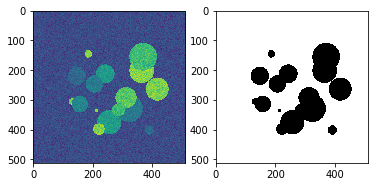

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

dataset = Ellipses()
image, gt = dataset[0]

plt.subplot(1,2,1)
plt.imshow(image[0].numpy())
plt.subplot(1,2,2)
plt.imshow(gt, cmap='gray')
plt.show()

Определим вспомогательную функцию:

In [3]:
import hashlib

def moy_variant(surname):
    return int(hashlib.md5(surname.encode().lower()).hexdigest()[-1], 16) % 2

In [5]:
moy_variant('Аношина')

1

Для решения этой задачи **реализуйте сеть EDANet** (https://arxiv.org/abs/1809.06323, если `moy_variant` от вашей фамилии на русском языке в именительном падеже выдает 1) **или BiSeNet** (https://arxiv.org/abs/1808.00897, иначе) на основе кодировщика двух предобученных сетей `torchvision` из семейств **ResNet и DenseNet**. В качестве лосса рекомендуется использовать `BCEWithLogitsLoss`.

In [3]:
from torchvision.models import *
import torchvision
import torch
from torch import nn
import torch.nn.functional as F


class EDAResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        model = resnet34(pretrained=True)
        self.backbone = nn.Sequential(model.conv1, model.bn1, model.relu,
                                      model.maxpool, model.layer1, model.layer2)
          
        self.project_layer = nn.Conv2d(128, num_classes, kernel_size=1)


    def forward(self, x):
        x = self.backbone(x)
        x = self.project_layer(x)
        
        x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=False)

        return x

class EDADenseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        model = densenet121(pretrained=True).features
        self.backbone = nn.Sequential(model.conv0, model.norm0, model.relu0,
                                     model.pool0, model.denseblock1, model.transition1,
                                     model.denseblock2)
        self.project_layer = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.project_layer(x)
        x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=False)
        return x


In [4]:
def dice_loss(input, target):
    
    intersection = (input * target).sum()
    
    return (2. * intersection) / (input.sum() + target.sum())

In [5]:
def train(model, opt, train_loader, test_loader, criterion, scheduler, n_epochs, \
          device, verbose=True):
    it = 0
    
    for epoch in range(n_epochs):
        model.eval()
        scheduler.step()
        for i, (images, labels) in enumerate(train_loader):
            images = images.float()
            labels = labels.float()
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(1), labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():
            total = 0
            train_loss = 0
            for images, labels in train_loader:
                images = images.float()
                labels = labels.float()
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                total += labels.size(0)
                train_loss += criterion(outputs.squeeze(1), labels)
            train_loss = train_loss / total
            writer.add_scalar('train_loss', train_loss, epoch)

            total = 0
            val_loss = 0
            diceloss = 0
            for images, labels in val_loader:
                images = images.float()
                labels = labels.float()
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                total += labels.size(0)
                val_loss += criterion(outputs.squeeze(1), labels)

                outputs = (F.sigmoid(outputs) > 0.5).float()
                diceloss += dice_loss(outputs, labels)
                writer.add_image('images', outputs[0,0].cpu().detach().numpy(), it)
                it += 1

            val_loss = val_loss / total
            diceloss = diceloss / total
            writer.add_scalar('val_loss', val_loss, epoch)
            writer.add_scalar('val_dice_loss', diceloss, epoch)
    
        if verbose:
                 print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f')
                       %(epoch+1, n_epochs, \
                         train_loss, val_loss))

In [12]:
from torch.utils.data import DataLoader
train_dataset = Ellipses(Nx=512, Ny=512, length=1000)
val_dataset =  Ellipses(Nx=512, Ny=512, length=300)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=False, num_workers=2)  # замечение про shuffle
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=2)  # замечение про shuffle


In [ ]:
from tensorboardX import SummaryWriter
from torch.optim import lr_scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

cnn = EDADenseNet(1)
log_dir = 'logs/edanet/seg_log_densenet4'
writer = SummaryWriter(log_dir)
learning_rate = 0.001
num_epochs = 20
cnn = cnn.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train(cnn, optimizer, train_loader, \
      val_loader, criterion, scheduler, num_epochs,\
      device, verbose=True)

Epoch [1/20], Loss (train/test): 0.0014/0.0016
Epoch [2/20], Loss (train/test): 0.0008/0.0008
Epoch [3/20], Loss (train/test): 0.0010/0.0010
Epoch [4/20], Loss (train/test): 0.0008/0.0008
Epoch [5/20], Loss (train/test): 0.0007/0.0007
Epoch [6/20], Loss (train/test): 0.0007/0.0007
Epoch [7/20], Loss (train/test): 0.0006/0.0007
Epoch [8/20], Loss (train/test): 0.0006/0.0007
Epoch [9/20], Loss (train/test): 0.0006/0.0007
Epoch [10/20], Loss (train/test): 0.0006/0.0007
Epoch [11/20], Loss (train/test): 0.0006/0.0007
Epoch [12/20], Loss (train/test): 0.0006/0.0007
Epoch [13/20], Loss (train/test): 0.0006/0.0007
Epoch [14/20], Loss (train/test): 0.0006/0.0007
Epoch [15/20], Loss (train/test): 0.0006/0.0007
Epoch [16/20], Loss (train/test): 0.0006/0.0007
Epoch [17/20], Loss (train/test): 0.0006/0.0007


In [12]:
from torch.utils.data import DataLoader
train_dataset = Ellipses(Nx=512, Ny=512, length=1000)
val_dataset =  Ellipses(Nx=512, Ny=512, length=300)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False, num_workers=2)  # замечение про shuffle
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=2)  # замечение про shuffle



In [13]:
from tensorboardX import SummaryWriter
from torch.optim import lr_scheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

cnn = EDAResNet(1)
log_dir = 'logs/edanet/seg_log_resnet'
writer = SummaryWriter(log_dir)
learning_rate = 0.003
num_epochs = 20
cnn = cnn.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train(cnn, optimizer, train_loader, \
      val_loader, criterion, scheduler, num_epochs,\
      device, verbose=True)

/home/nadya/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20], Loss (train/test): 0.0109/0.0144
Epoch [2/20], Loss (train/test): 0.0022/0.0044
Epoch [3/20], Loss (train/test): 0.0015/0.0023
Epoch [4/20], Loss (train/test): 0.0010/0.0020
Epoch [5/20], Loss (train/test): 0.0008/0.0029
Epoch [6/20], Loss (train/test): 0.0008/0.0013
Epoch [7/20], Loss (train/test): 0.0007/0.0015
Epoch [8/20], Loss (train/test): 0.0007/0.0017
Epoch [9/20], Loss (train/test): 0.0007/0.0018
Epoch [10/20], Loss (train/test): 0.0007/0.0020
Epoch [11/20], Loss (train/test): 0.0007/0.0020
Epoch [12/20], Loss (train/test): 0.0007/0.0020
Epoch [13/20], Loss (train/test): 0.0007/0.0020
Epoch [14/20], Loss (train/test): 0.0007/0.0019
Epoch [15/20], Loss (train/test): 0.0007/0.0019
Epoch [16/20], Loss (train/test): 0.0007/0.0019
Epoch [17/20], Loss (train/test): 0.0007/0.0020
Epoch [18/20], Loss (train/test): 0.0007/0.0020
Epoch [19/20], Loss (train/test): 0.0007/0.0020
Epoch [20/20], Loss (train/test): 0.0007/0.0021


**Проиллюстрируйте процесс обучения** сети скриншотами из `tensorboard` (см. `lanpa/tensorboardX`).

Необходимо в частности отобразить кривую обучения и примеры эволюции качества выдаваемых масок.

За декодировщик был взят Projection_layer сети EDANet.
По результатам работы нейросети EDANET на основе кодировщиков ResNet и DenseNet можно сделать вывод, что Resnet работает быстрее (в результате использования ResNet34 и DenseNet121)
Для обучения был использован lr_scheduler и Adam. Для устранения нестабильности в результате Batchnorm2d слоев модель обучалась при model.eval().

In [11]:
from PIL import Image
from matplotlib import pyplot as plt
from scipy import misc
%matplotlib inline

## EDANet c DenseNet


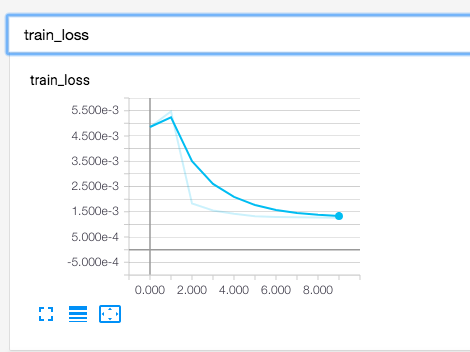

In [4]:
Image.open('imgs/dense_train_loss.png')

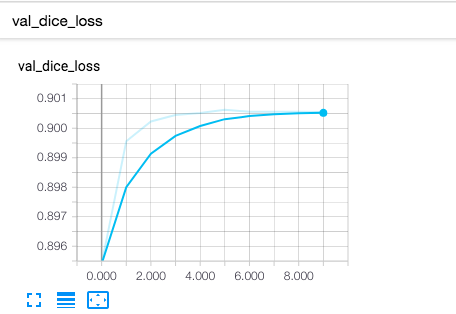

In [5]:
Image.open('imgs/dense_dice_loss.png')

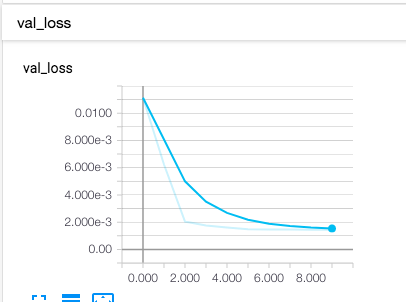

In [3]:
Image.open('imgs/dense_val_loss.png')

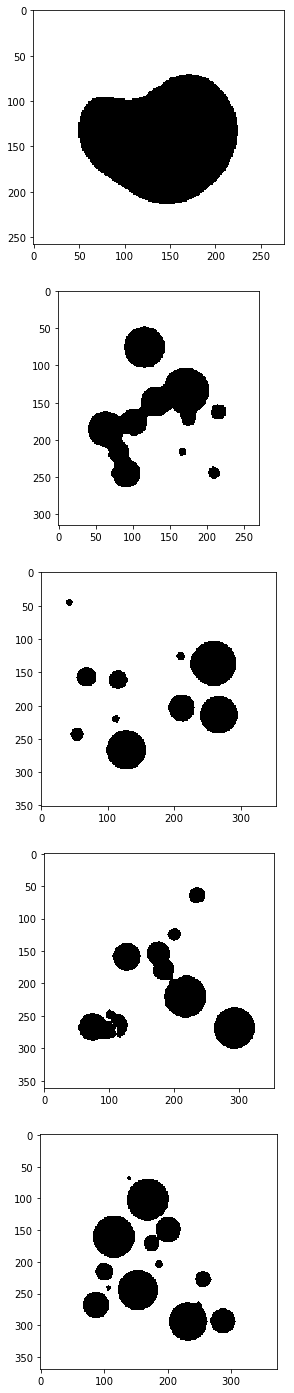

In [16]:
fig = plt.figure(figsize=(5, 25))
plt.subplot(5,1,1)
plt.imshow(misc.imread('imgs/dense_im1.png'))
plt.subplot(5,1,2)
plt.imshow(misc.imread('imgs/dense_im2.png'))
plt.subplot(5,1,3)
plt.imshow(misc.imread('imgs/dense_im3.png'))
plt.subplot(5,1,4)
plt.imshow(misc.imread('imgs/dense_im4.png'))
plt.subplot(5,1,5)
plt.imshow(misc.imread('imgs/dense_im5.png'))
plt.show()

## EDANet c ResNet


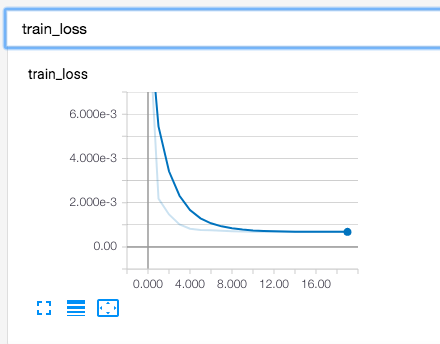

In [8]:
Image.open('imgs/resnet_train_loss.png')

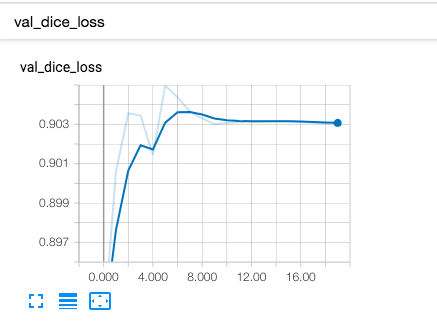

In [9]:
Image.open('imgs/resnet_dice_loss.png')

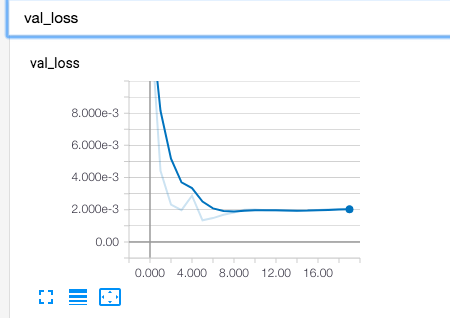

In [10]:
Image.open('imgs/resnet_val_loss.png')

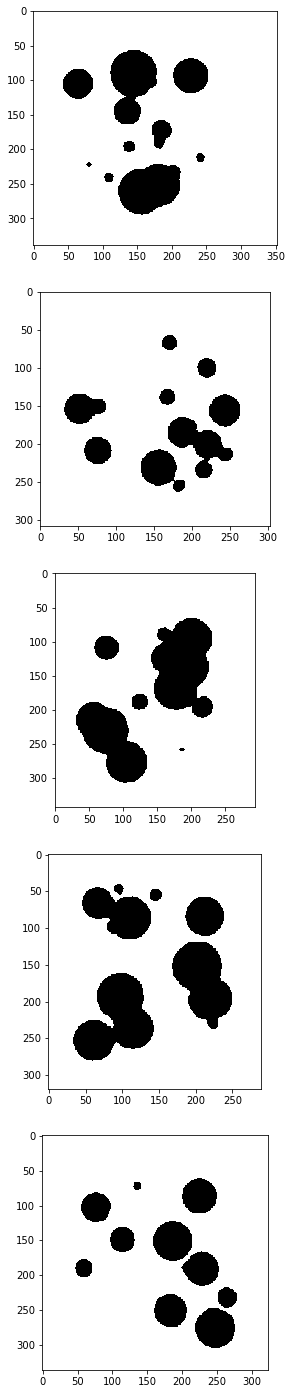

In [17]:
fig = plt.figure(figsize=(5, 25))
plt.subplot(5,1,1)
plt.imshow(misc.imread('imgs/resnet_im1.png'))
plt.subplot(5,1,2)
plt.imshow(misc.imread('imgs/resnet_im2.png'))
plt.subplot(5,1,3)
plt.imshow(misc.imread('imgs/resnet_im3.png'))
plt.subplot(5,1,4)
plt.imshow(misc.imread('imgs/resnet_im4.png'))
plt.subplot(5,1,5)
plt.imshow(misc.imread('imgs/resnet_im5.png'))
plt.show()